In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

def stft( input_sound, dft_size, hop_size, zero_pad, window):
    # YOUR CODE HERE
    f = []
    for i in range(0, len(input_sound), hop_size):
        if i+dft_size > len(input_sound):
            vec = input_sound[i:]
        else:
            vec = input_sound[i:i+dft_size]
        vec = np.pad(vec, (0, dft_size-len(vec)), 'constant') * np.array(window)
        f.append(np.fft.rfft(vec, n=dft_size+zero_pad))
        
    # Return a complex-valued spectrogram (frequencies x time)
    return np.array(f, dtype=complex)

def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display( HTML( 
    '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
    '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
    ))

def istft( stft_output, dft_size, hop_size, zero_pad, window):
    # YOUR CODE HERE
    isft = np.fft.irfft(stft_output, n=dft_size+zero_pad) * np.array(window)
    n_frames = len(stft_output)
    x = np.zeros(n_frames*hop_size+dft_size+zero_pad)
    for i in range(n_frames):
        x[i*hop_size:i*hop_size+dft_size+zero_pad] += isft[i]
    # Return reconstructed waveform
    return x

In [40]:
def generate_sawtooth_wave(freq, duration, sample_rate):
    t = np.linspace(0, duration, int(duration * sample_rate), endpoint=False)
    wave = 2 * (t * freq - np.floor(0.5 + t * freq))  # Sawtooth wave formula
    return wave

# Parameters for the sawtooth wave
frequency = 110  # Frequency in Hz (A4 note)
duration = 69009/22050  # Duration in seconds
sr_carrier = 22050  # Sample rate in Hz

# Generate the sawtooth wave
carrier = generate_sawtooth_wave(frequency, duration, sr_carrier)

sound(carrier, rate=sr_carrier)

""


In [41]:
import librosa

# Load the two audio signals
modulator, sr_modulator = librosa.load('samples/speech.wav')

sound(modulator, rate=sr_modulator)

""


In [42]:
print(len(modulator))

69009


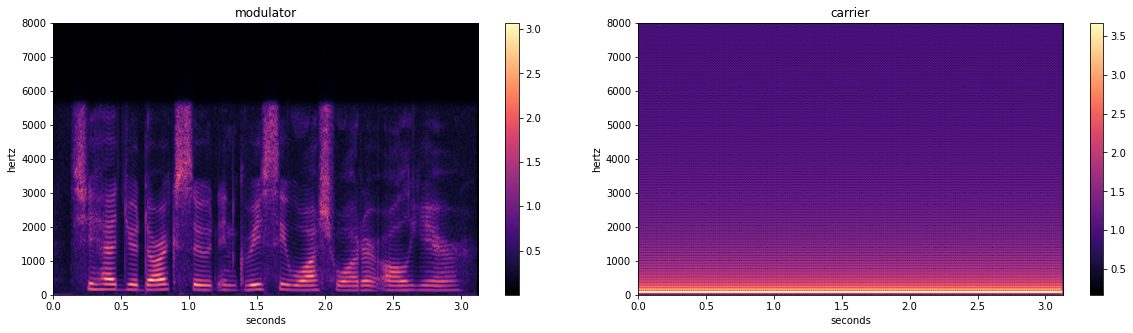

In [43]:
window = np.hanning(512)
modulator_stft = stft(modulator, 512, 128, 16, window)
carrier_stft = stft(carrier, 512, 128, 16, window)

cmap = plt.cm.magma
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.subplots_adjust(wspace=0.1)

for z, ax in zip([(modulator_stft, 'modulator', modulator, sr_modulator), (carrier_stft, 'carrier', carrier, sr_carrier)], axes):
    im = ax.imshow(np.absolute(z[0].T)**0.3, cmap=cmap, origin='lower', extent=[0, len(z[2])/z[3], 0, 256*31.25], aspect="auto")
    ax.set_title(z[1])
    ax.set_xlabel('seconds')
    ax.set_ylabel('hertz')
    fig.colorbar(im, ax=ax)

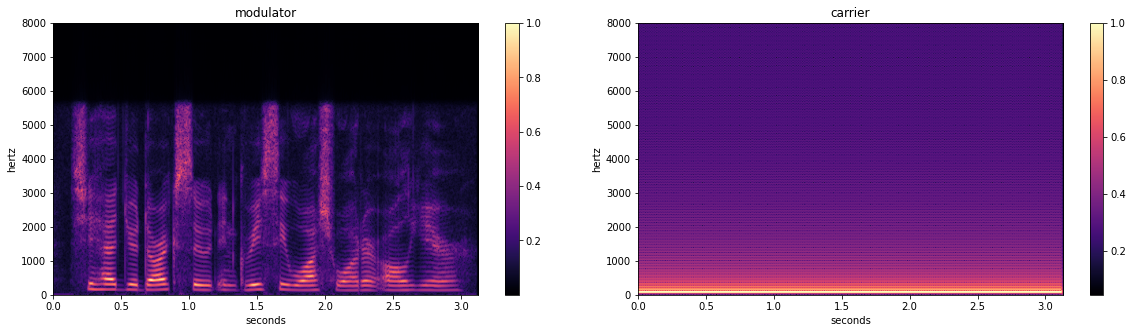

In [44]:
def compute_spectral_envelope(stft_matrix, smoothing_window_size, downsampling_factor):
    # Step 1: Compute the magnitude spectrum
    magnitude_spectrum = np.abs(stft_matrix)

    # Step 2: Smooth the magnitude spectrum
    window = np.ones(smoothing_window_size) / smoothing_window_size
    smoothed_spectrum = np.apply_along_axis(lambda m: np.convolve(m, window, mode='same'), axis=1, arr=magnitude_spectrum)

    # Step 3: Downsample the smoothed spectrum
    downsampled_spectrum = smoothed_spectrum[:, ::downsampling_factor]

    # Step 4: Interpolate the downsampled spectrum
    interpolated_spectrum = np.repeat(downsampled_spectrum, downsampling_factor, axis=1)

    # Step 5: Normalize the spectral envelope
    spectral_envelope = interpolated_spectrum / np.max(interpolated_spectrum)

    return spectral_envelope

modulator_envelope = compute_spectral_envelope(modulator_stft, smoothing_window_size=1, downsampling_factor=1)
carrier_envelope = compute_spectral_envelope(carrier_stft, smoothing_window_size=1, downsampling_factor=1)


cmap = plt.cm.magma
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.subplots_adjust(wspace=0.1)

for z, ax in zip([(modulator_envelope, 'modulator', modulator, sr_modulator), (carrier_envelope, 'carrier', carrier, sr_carrier)], axes):
    im = ax.imshow(np.absolute(z[0].T)**0.3, cmap=cmap, origin='lower', extent=[0, len(z[2])/z[3], 0, 256*31.25], aspect="auto")
    ax.set_title(z[1])
    ax.set_xlabel('seconds')
    ax.set_ylabel('hertz')
    fig.colorbar(im, ax=ax)

In [45]:
carrier_divided = carrier_stft*carrier_envelope

In [46]:
print(carrier_divided)

[[-1.86950722e-01+0.00000000e+00j -1.50506340e+00-4.33425851e-01j
   4.87265918e+01+1.82641026e+01j ...  4.60516046e-03+1.23567721e-02j
  -6.86703795e-03-7.26086964e-04j  2.08436041e-02+0.00000000e+00j]
 [ 5.49054305e-02+0.00000000e+00j  7.15164278e-01+1.39033818e+00j
  -1.78503491e+01-5.06885151e+01j ...  5.67063948e-04-1.09558045e-02j
  -3.32539448e-03+1.97176839e-02j  5.35916351e-04+0.00000000e+00j]
 [ 4.16142698e-02+0.00000000e+00j  4.75575912e-01-1.17681806e+00j
  -2.64175269e+01+4.67297556e+01j ... -1.08849892e-02+8.50243309e-03j
   1.19097485e-02-6.64635307e-04j -1.52820424e-02+0.00000000e+00j]
 ...
 [-3.54616362e-01+0.00000000e+00j  3.41075501e-01+3.33834459e+00j
   1.19327967e+01-1.00297623e+01j ... -6.28387956e-04+5.89018014e-04j
  -1.19365910e-03+2.61936409e-03j  6.69531154e-03+0.00000000e+00j]
 [ 2.71532604e-01+0.00000000e+00j -1.06779762e-01-3.92407826e-01j
  -6.54465411e-01+1.38108032e-01j ... -3.09199228e-04-9.47415062e-05j
  -4.78937741e-05+3.19787386e-04j  3.23342951e-

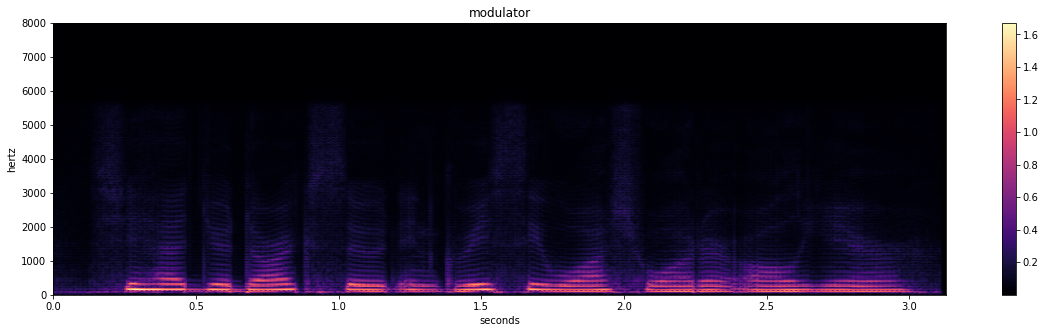

In [47]:
vocoded_stft = modulator_envelope * carrier_divided
cmap = plt.cm.magma
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
fig.subplots_adjust(wspace=0.1)

z = (vocoded_stft, 'modulator', modulator, sr_modulator)
im = ax.imshow(np.absolute(z[0].T)**0.3, cmap=cmap, origin='lower', extent=[0, len(z[2])/z[3], 0, 256*31.25], aspect="auto")
ax.set_title(z[1])
ax.set_xlabel('seconds')
ax.set_ylabel('hertz')
fig.colorbar(im, ax=ax)

In [48]:
window = np.hanning(512+16)
vocoded = istft(vocoded_stft, 512, 128, 16, window)
sound(vocoded, rate=sr_modulator)

""


In [49]:
from pydub import AudioSegment
from pydub.effects import compress_dynamic_range

compressed_audio = compress_dynamic_range(vocoded, threshold=-20, ratio=5.0, attack=10, release=200)

sound(compressed_audio, rate=sr_modulator)

AttributeError: 'numpy.ndarray' object has no attribute 'max_possible_amplitude'